# Table of Contents
 <p>

In [1]:
from __future__ import print_function
%matplotlib inline
from matplotlib.pylab import plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import numpy as np
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D
from keras.optimizers import SGD
import time
from keras.models import model_from_json


# create dictionary with train, unseen_house, unseen_appliance
def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in activations.iteritems():
        for appliance, buildings in appliances.iteritems():
            required_building_ids = windows[fold].keys()
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return activations    



NILMTK_FILENAME = './redd_data/redd.h5'
SAMPLE_PERIOD = 6
STRIDE = None
APPLIANCES = ['fridge']
WINDOWS = {
    'train': {
        1: ("2011-04-19", "2011-05-21"),
        2: ("2011-04-19", "2013-05-01"),
        3: ("2011-04-19", "2013-05-26"),
        6: ("2011-05-22", "2011-06-14"),
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2011-04-19", None),
        2: ("2011-04-19", None),
        3: ("2011-04-19", None),
        6: ("2011-05-22", None),
    },
    'unseen_appliances': {
        5: ("2011-04-19", None)
    }
}

# get the dictionary of activations for each appliance
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

# get pipeline for the fridge example
num_seq_per_batch = 64
target_appliance = 'fridge'
seq_length = 512
train_buildings = [1, 2, 3, 6]
unseen_buildings = [5]
DATA_FOLD_NAMES = (
    'train', 'unseen_appliances', 'unseen_activations_of_seen_appliances')

filtered_windows = select_windows(train_buildings, unseen_buildings)
filtered_activations = filter_activations(filtered_windows, activations)

synthetic_agg_source = SyntheticAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    sample_period=SAMPLE_PERIOD
)

real_agg_source = RealAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    filename=NILMTK_FILENAME,
    windows=filtered_windows,
    sample_period=SAMPLE_PERIOD
)


# ------------
# needed to rescale the input aggregated data
# rescaling is done using the a first batch of num_seq_per_batch sequences
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
# ------------



pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)

Using Theano backend.
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=9)
  data = data.resample(**resample_kwargs)


Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/pandas/tseries/base.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = getitem(key)
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:332: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return resampled.index[0]
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=5)
  

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [16]:
exp_number = 13
output_architecture = './tmpdata/convnet_architecture_exp' + str(exp_number) + '.json'
best_weights_during_run = './tmpdata/weights_exp' + str(exp_number) + '.h5'
final_weights = './tmpdata/weights_exp' + str(exp_number) + '_final.h5'
model = model_from_json(open(output_architecture).read())
# load intermediate or final weights
model.load_weights(best_weights_during_run)
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()
# load the loss summary
import pickle
losses = pickle.load( open('./tmpdata/history_exp' + str(exp_number) + '.pickle'   , 'rb'))

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 512, 1)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 510, 16)     64          input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)                (None, 8160)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                    (None, 1024)        8356864     flatten_1[0][0]                  
___________________________________________________________________________________________

{'f1_score': 0.78358998471846719, 'recall_score': 0.99700867484295541, 'precision': 0.64542989930286598, 'accuracy': 0.71519183168316836}


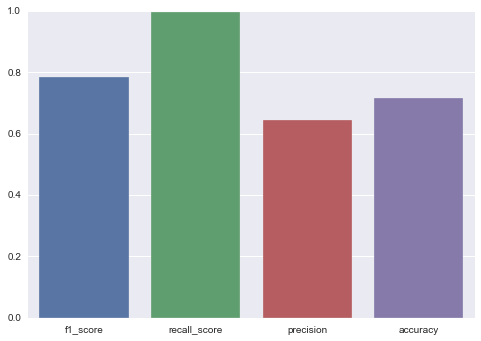

In [17]:
# report score on seen
from neuralnilm.scores import scores
num_test_seq = 101
Y_test = np.empty((64*num_test_seq,3))
Y_pred = np.empty((64*num_test_seq,3))
for i in range(num_test_seq):
    (x_test, y_test) = pipeline.train_generator(fold = 'train', source_id = 1).next()
    Y_test[64*i: 64*(i+1)] = y_test
    Y_pred[64*i: 64*(i+1)] = model.predict_on_batch(x_test)
results = scores(Y_pred, Y_test)
print
print(results)

In [18]:
# report score on unseen builing
from neuralnilm.scores import scores, plot_loss
num_test_seq = 101
Y_test = np.empty((64*num_test_seq,3))
Y_pred = np.empty((64*num_test_seq,3))
for i in range(num_test_seq):
    (x_test, y_test) = pipeline.train_generator(fold = 'unseen_appliances', source_id = 1).next()
    Y_test[64*i: 64*(i+1)] = y_test
    Y_pred[64*i: 64*(i+1)] = model.predict_on_batch(x_test)

number of Predicted negatives: 1353
number of Predicted positives: 5111
number of Observed negatives: 3280
number of Observed positives: 3184
f1: 0.764074743822
precision : 0.620035218157
recall :  0.995288944724
accuracy: 0.697246287129
{'f1_score': 0.76407474382157914, 'recall_score': 0.99528894472361806, 'precision': 0.62003521815691642, 'accuracy': 0.69724628712871284}


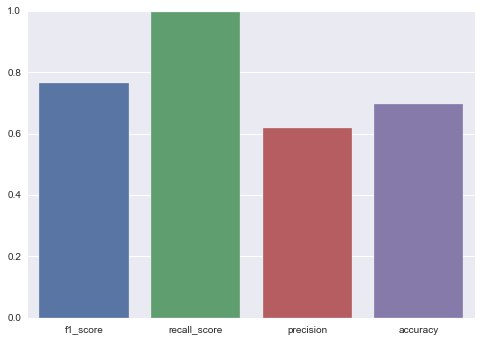

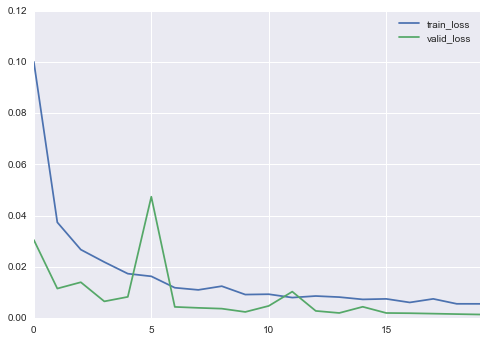

In [19]:
results = scores(Y_pred, Y_test, activation_threshold = 1e-3, print_results=True)
print
print(results)
plot_loss(losses)

In [43]:
from matplotlib import rcParams

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


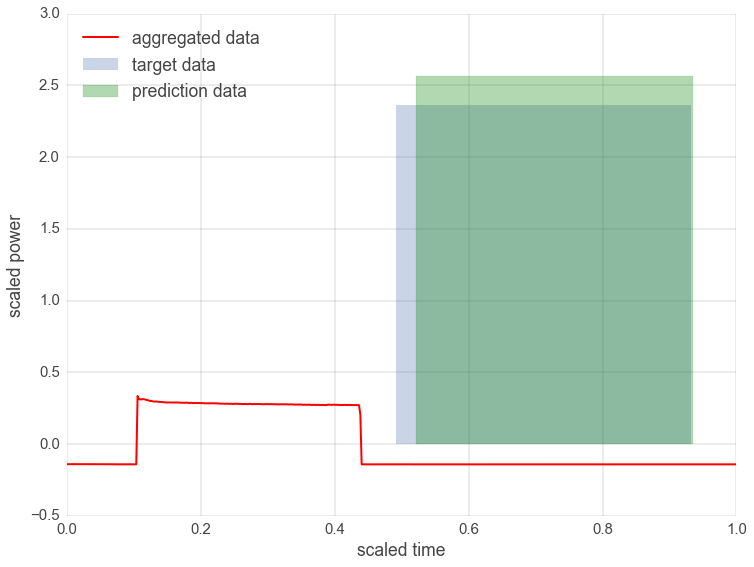

In [48]:
from neuralnilm.scores import plot_rectangle
test_value = 3
x_v = np.linspace(0,1,x_test[test_value,:].shape[0])
plt.plot(x_v,x_test[test_value,:], label = 'aggregated data', color = 'r')
rectangle = Y_test[test_value,:]
plt.fill_between(rectangle[0:2],0, rectangle[2], alpha = 0.3, label = 'target data')
rectangle = Y_pred[test_value,:]
plt.fill_between(rectangle[0:2],0, rectangle[2], alpha = 0.3, label = 'prediction data', color = 'g')
plt.legend(loc = 2);
plt.ylabel('scaled power')
plt.xlabel('scaled time')